In [400]:
import numpy as np
import pandas as pd
import datetime
import seaborn
seaborn.set(style='ticks')

import re
pd.set_option('display.max_columns', None)

import statsmodels.formula.api as smf 
import statsmodels.api as sm  


In [401]:
# import data from CSV
state_df = pd.read_csv("cleaned_OI_state_data.csv")

month_to_num = {'jan' : '01',
                'feb' : '02', 
                'mar' : '03',
                'apr' : '04',
                'may' : '05',
                'jun' : '06',
                'jul' : '07',
                'aug' : '08',
                'sep' : '09',
                'oct' : '10',
                'nov' : '11',
                'dec' : '12',
               }

In [402]:
# convert string representations of months in the dataframe to numerical representations
state_df = state_df.replace(month_to_num, regex = True)

# convert date columns in the data frame from string type to datetime type
date_columns = ['date', 'close_nonessential_bus', 'begin_reopen', 'mandate_mask', 'begin_shelter_in_place']
state_df[date_columns] = state_df[date_columns].apply(pd.to_datetime, format = "%d%m%Y")

In [545]:
# extract a dataframe of the spending variables chose, by date and by state
spending = state_df[['date', 
                     'state', 
                     'spend_all', 
                     'spend_all_inchigh', 
                     'spend_all_inclow', 
                    'spend_all_incmiddle',
                    'spend_acf',
                    'spend_aer',
                    'spend_apg',
                    'spend_grf',
                    'spend_hcs',
                    'spend_tws']]

# Examining similarity of matches 

In [546]:
def plt_comp_graph(spending, states_for_comp, treat, end):
    '''
    This function takes in the following arguments
    - spending- this is the dataframe constructed of spending variables, by date and by state
    - states_for_comp- this a list, of the form ['state name 1', 'state name 2'], 
        containing the lists to be compared
    - treat- this is the date where the treatment group receives the treatment to be studied
             this is inputted in string format 'YYYYmmdd'
    - end - this is the last date where the control group has not received the studied treatment or 
            any subsequent treatment, and where the treatment group has not received a treatment beyond the 
            treatment to be studied
            this is inputted in string format 'YYYYmmdd'
    '''
    
    # this restricts the dataframe to the states to be studied, the spend_all variable, and indexes by date
    temp_df = spending[spending['state'].isin(states_for_comp)].set_index('date')[['state',
                                                                                  'spend_all']]
    
    # this concats the dataframe, so that each row has the spending data for both states on a given date
    spending_comp = pd.concat([temp_df[temp_df['state'] == states_for_comp[0]].rename(columns = 
                                                                                    {'spend_all' : states_for_comp[0]})
                   , temp_df[temp_df['state'] ==  states_for_comp[1]].rename(columns = 
                                                        {'spend_all' : states_for_comp[1]})]
                  , axis = 1)
    
    # the following code plots spending over time 
    plt.plot(spending_comp[[states_for_comp[0], states_for_comp[1]]])
    plt.legend([states_for_comp[0], states_for_comp[1]])
    
    # this blue vertical line indicates treatment date
    plt.axvline(pd.to_datetime(treat, format = '%Y%m%d'))
    # this red vertical line indicates the last valid data point to be used in regression
    plt.axvline(pd.to_datetime(end, format = '%Y%m%d'), color = 'red')
    plt.ylabel("spend_all")
    plt.xlabel("date")

    

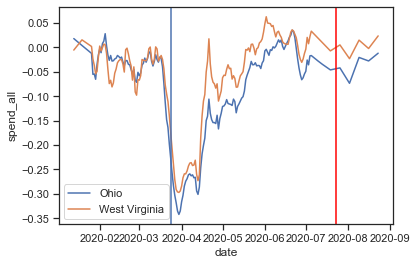

In [547]:
plt_comp_graph(spending, ['Ohio', 'West Virginia'], '20200324', '20200723')
plt.savefig("ohwv.png")

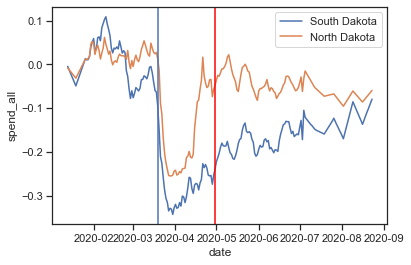

In [548]:
plt_comp_graph(spending, ['South Dakota', 'North Dakota'], '20200319', '20200430')
plt.savefig("sdnd.png")

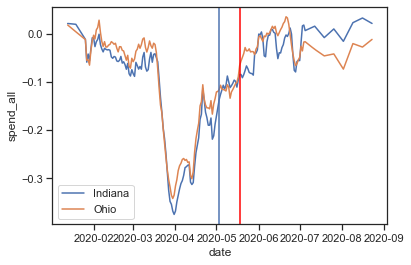

In [549]:
plt_comp_graph(spending, ['Indiana', 'Ohio'], '20200503', '20200518')
plt.savefig("inoh.png")

# constructing dataframes for regression

In [495]:
def get_comp_df(spending, states_for_comp, start, treat, end):
    '''
    This function requires that states_for_comp is a list of size two
    where the first element is the state name of the state used 
    as a control group, and the second is the name of the state used
    as the treatment group. [control, treatment]
    
    start - this is the first date where control and treatment state 
            have received identical treatments till this date, in the form 'YYYYmmdd'
    treat - this is the date on which the treatment state receives 
            treatment, in the form 'YYYYmmdd'
    end - this is the last date of valid data to be used in regression, in the form 'YYYYmmdd'
    
    '''
    
    temp_df = spending[spending['state'].isin(states_for_comp)].set_index('date')
    spending_comp = pd.concat([temp_df[temp_df['state'] == states_for_comp[0]]
                   , temp_df[temp_df['state'] ==  states_for_comp[1]]]
                  , axis = 0)
    df =  spending_comp.reset_index()
    
    #filter to start and end date
    df = df[df['date']>= pd.to_datetime(start, format='%Y%m%d')]
    df = df[df['date']<= pd.to_datetime(end, format='%Y%m%d')]
    
    # labels the treatment group
    df['treatment_group'] = df['state'] == states_for_comp[1]
    
    #labels time period 2
    df['T2'] = df['date'] > pd.to_datetime(treat, format='%Y%m%d')
    
    # constructs the interaction term
    df['T2_treatment'] = df['treatment_group']*df['T2']
    return df


In [508]:
# constructs dataframes for regressions on the matchings determined
oh_wv_spend = get_comp_df(spending, \
                          ['Ohio', 'West Virginia'],\
                         '20200101', '20200706', '20200723')
sd_nd_spend = get_comp_df(spending, \
                          ['South Dakota', 'North Dakota'],\
                         '20200101', '20200319', '20200430')
in_oh_spend = get_comp_df(spending, \
                          ['Indiana', 'Ohio'],\
                         '20200326', '20200503', '20200518')
dfs = [oh_wv_spend, sd_nd_spend, in_oh_spend]

In [509]:
titles = ['Ohio, West Virginia, mask mandate', 
          'South Dakota, North Dakota, close nonessential bus',
         'Indiana, Ohio, begin reopening']

In [520]:
#runs regression for each pair of states
for i in range(len(dfs)):
    curr_df = dfs[i]
    title = titles[i]
    for spending_var in (['spend_all', 
                     'spend_all_inchigh', 
                     'spend_all_inclow', 
                    'spend_all_incmiddle',
                    'spend_acf',
                    'spend_aer',
                    'spend_apg',
                    'spend_grf',
                    'spend_hcs',
                    'spend_tws']):
        model = smf.ols(formula = spending_var + " ~ T2_treatment + treatment_group + T2", data = curr_df).fit()
        print(title)
        print(model.summary())

Ohio, West Virginia, mask mandate
                            OLS Regression Results                            
Dep. Variable:              spend_all   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     6.737
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           0.000194
Time:                        11:19:25   Log-Likelihood:                 392.43
No. Observations:                 386   AIC:                            -776.9
Df Residuals:                     382   BIC:                            -761.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

South Dakota, North Dakota, close nonessential bus
                            OLS Regression Results                            
Dep. Variable:              spend_grf   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     11.20
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           7.45e-07
Time:                        11:19:26   Log-Likelihood:                 144.23
No. Observations:                 218   AIC:                            -280.5
Df Residuals:                     214   BIC:                            -266.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

# Extracting policy implementation dates and governor political part

In [543]:
state_dates = state_df[['close_nonessential_bus', 
                'begin_reopen', 
                'mandate_mask', 
                'begin_shelter_in_place', 
                'statefips', 
                'governor_party',
                'state',
                'state_pop2019']].groupby('statefips').agg('first').reset_index()

In [544]:
state_dates

,statefips,close_nonessential_bus,begin_reopen,mandate_mask,begin_shelter_in_place,governor_party,state,state_pop2019
0,1,2020-03-28,2020-04-30,2020-07-16,2020-04-04,Republican,Alabama,4903185
1,2,2020-03-28,2020-04-24,2020-04-24,2020-03-28,Republican,Alaska,731545
2,4,2020-03-30,2020-05-08,NaT,2020-03-31,Republican,Arizona,7278717
3,5,2020-04-04,2020-05-04,2020-07-20,NaT,Republican,Arkansas,3017804
4,6,2020-03-19,2020-05-08,2020-06-18,2020-03-19,Democratic,California,39512223
5,8,2020-03-26,2020-05-01,2020-07-16,2020-03-26,Democratic,Colorado,5758736
6,9,2020-03-23,2020-05-20,2020-04-20,NaT,Democratic,Connecticut,3565287
7,10,2020-03-24,2020-05-08,2020-04-28,2020-03-24,Democratic,Delaware,973764
8,11,2020-03-25,2020-05-29,2020-04-17,2020-04-01,Republican,District of Columbia,705749
9,12,2020-03-20,2020-05-18,NaT,2020-04-03,Republican,Florida,21477737
